In [ ]:
import xarray as xr
import glob
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, guvectorize, float32, float64, boolean
import hvplot.xarray 
import cartopy.crs as ccrs

In [ ]:
root_path = '/projekt4/hochatm/akuchar/ICON/dwd/icon/u/opendata.dwd.de/weather/nwp/icon/grib/06/'
xr.set_options(display_style='html', keep_attrs = True)

# Grib

In [4]:
sel_var = 'u'
ds = xr.open_dataset(f'{root_path}{sel_var}/icon_global_icosahedral_model-level_2021010506_120_9_{sel_var.upper()}.grib2', engine = 'cfgrib')
ds


ecCodes provides no latitudes/longitudes for gridType='unstructured_grid'


<xarray.Dataset>
Dimensions:               (values: 2949120)
Coordinates:
    time                  datetime64[ns] ...
    step                  timedelta64[ns] ...
    generalVerticalLayer  int64 ...
    valid_time            datetime64[ns] ...
Dimensions without coordinates: values
Data variables:
    u                     (values) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach 
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach 
    history:                 2021-01-05T16:24:23 GRIB to CDM+CF via cfgrib-0....

In [13]:
sel_var = 'u'
infiles = sorted(glob.glob(f'{root_path}{sel_var}/*.grib2'))


In [17]:
sel_var = 'p'
ds = xr.open_mfdataset([infiles[:90],infiles[90:180]], engine = 'cfgrib', 
                       combine='nested', concat_dim=['step','generalVerticalLayer'], parallel=False, 
                       backend_kwargs={'errors': 'ignore'}).sortby('generalVerticalLayer')

In [20]:
ds.sortby('generalVerticalLayer')

<xarray.Dataset>
Dimensions:               (generalVerticalLayer: 90, step: 2, values: 2949120)
Coordinates:
    valid_time            (step) datetime64[ns] 2021-01-05T06:00:00 2021-01-0...
    time                  datetime64[ns] 2021-01-05T06:00:00
  * step                  (step) timedelta64[ns] 00:00:00 01:00:00
  * generalVerticalLayer  (generalVerticalLayer) int64 1 2 3 4 5 ... 87 88 89 90
Dimensions without coordinates: values
Data variables:
    u                     (generalVerticalLayer, step, values) float32 dask.array<chunksize=(1, 1, 2949120), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach 
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach 
    history:                 2021-01-05T16:35:01 GRIB to CDM+CF via cfgrib-0....

In [18]:
ds

<xarray.Dataset>
Dimensions:               (generalVerticalLayer: 90, step: 2, values: 2949120)
Coordinates:
    valid_time            (step) datetime64[ns] 2021-01-05T06:00:00 2021-01-0...
    time                  datetime64[ns] 2021-01-05T06:00:00
  * step                  (step) timedelta64[ns] 00:00:00 01:00:00
  * generalVerticalLayer  (generalVerticalLayer) int64 10 11 12 13 ... 89 8 90 9
Dimensions without coordinates: values
Data variables:
    u                     (generalVerticalLayer, step, values) float32 dask.array<chunksize=(1, 1, 2949120), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach 
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach 
    history:                 2021-01-05T16:35:01 GRIB to CDM+CF via cfgrib-0....

# Netcdf

In [77]:
time_ls = list(range(78))+list(range(81,123,3))
sel_var = 'p'
infiles = [sorted(glob.glob(f'{root_path}{sel_var}/nc/*_{time:03d}_*.nc')) for time in time_ls]

In [85]:
ds = xr.open_mfdataset(infiles[:-1], engine = 'netcdf4',
                       combine='nested', concat_dim=['time','height'], parallel=True, 
                       ).sortby('height')

In [87]:
time_ls = list(range(78))+list(range(81,123,3))
sel_var = 'u'
infiles = [sorted(glob.glob(f'{root_path}{sel_var}/nc/*_{time:03d}_*.nc')) for time in time_ls]

In [88]:
ds_u = xr.open_mfdataset(infiles[:-1], engine = 'netcdf4',
                       combine='nested', concat_dim=['time','height'], parallel=True, 
                       ).sortby('height')

In [103]:
ds_all = xr.merge([ds,ds_u]).chunk({'height': -1})
ds_all

<xarray.Dataset>
Dimensions:      (bnds: 2, height: 90, lat: 721, lon: 1440, time: 91)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-05T06:00:00 ... 2021-01-10T03:...
  * lat          (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon          (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * height       (height) float64 1.5 2.5 3.5 4.5 5.5 ... 87.5 88.5 89.5 90.5
Dimensions without coordinates: bnds
Data variables:
    height_bnds  (time, height, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    pres         (time, height, lat, lon) float32 dask.array<chunksize=(1, 90, 721, 1440), meta=np.ndarray>
    u            (time, height, lat, lon) float32 dask.array<chunksize=(1, 90, 721, 1440), meta=np.ndarray>

In [96]:
@guvectorize(
    [
        (float64[:], float64[:], float64[:], boolean, float64[:]),
        (float32[:], float32[:], float32[:], boolean, float32[:]),
    ],
    "(n),(n),(m),()->(m)",
    nopython=True,
)
def _interp_1d_linear(phi, theta, target_theta_levels, mask_edges, output):
    # if last theta value is smaller than first, assume the profile is monotonically decreasing and flip
    if theta[-1] < theta[0]:
        theta = np.flip(theta)
        phi = np.flip(phi)

    output[:] = np.interp(target_theta_levels, theta, phi)

    if mask_edges:
        theta_max = np.nanmax(theta)
        theta_min = np.nanmin(theta)
        for i in range(len(target_theta_levels)):
            theta_lev = target_theta_levels[i]
            if (theta_lev < theta_min) or (theta_lev > theta_max):
                output[i] = np.nan


def interp_1d_linear(phi, theta, target_theta_levels, mask_edges=False):
    """
    Vectorized interpolation of scalar phi to isosurfaces of scalar theta
    along the final axis.
    Parameters
    ----------
    phi : array_like
        Array of shape (..., n), scalar field to be interpolated
    theta : array_like
        Array of shape (..., n), scalar field which defines the isosurfaces
    target_theta_levels : array_like
        Array of shape (m) specificying target isosurface levels
    mask_edges : bool, optional
        Determines how to handle theta values that exceed the bounds of
        target_theta_levels. If False, fill with nearest valid values. If
        True, fill with NaNs.
    Returns
    -------
    phi_interp : array
        Array of shape (..., m) of phi interpolated to theta isosurfaces.
    """
    return _interp_1d_linear(phi, theta, target_theta_levels, mask_edges)


def linear_interpolation(
    phi, theta, target_theta_levels, phi_dim, theta_dim, target_dim, **kwargs):
    out = xr.apply_ufunc(
        interp_1d_linear,
        phi,
        theta,
        target_theta_levels,
        kwargs=kwargs,
        input_core_dims=[[phi_dim], [theta_dim], [target_dim]],
        output_core_dims=[[target_dim]],
        exclude_dims=set((phi_dim,)),
        dask="parallelized",
        output_dtypes=[np.float32],
    )
    out[target_dim] = target_theta_levels
    return out

In [100]:
ds_all['pres'].min().values

array(1.0478556, dtype=float32)

In [104]:
vert_c_name = 'height'
plevc = np.array([100000,92500,85000,77500,70000,60000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,1000,
                  700,500,300,200,100,70,50,30,20,10])
zi = xr.DataArray(plevc, dims='lvl')

ds_out = linear_interpolation(ds_all['u'], 
                              ds_all['pres'], 
                              plevc,
                              vert_c_name, 
                              vert_c_name, 
                              'lvl')
ds_out

,Array,Chunk
Bytes,10.20 GB,112.13 MB
Shape,"(91, 721, 1440, 27)","(1, 721, 1440, 27)"
Count,82356 Tasks,91 Chunks
Type,float32,numpy.ndarray


In [107]:
temp = ds_out.sel(lat = 60, method = 'nearest').mean('lon').load()
temp

<xarray.DataArray (time: 91, lvl: 27)>
array([[ -0.32513803,   0.7663503 ,   0.76255053, ..., -42.808167  ,
        -38.269264  , -26.220194  ],
       [ -0.28740364,   0.9709645 ,   1.0703743 , ..., -42.691986  ,
        -36.300755  , -24.21239   ],
       [ -0.18572786,   1.1949017 ,   1.3073009 , ..., -42.268047  ,
        -34.13162   , -22.628252  ],
       ...,
       [ -0.6626521 ,   0.46731508,   1.7747891 , ...,  28.41698   ,
         26.559784  ,  27.857063  ],
       [ -0.30443296,   0.85236484,   1.7570733 , ...,  27.263754  ,
         26.273773  ,  26.551952  ],
       [ -0.20005277,   0.81955457,   1.5956417 , ...,  28.543123  ,
         26.663364  ,  24.076254  ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-05T06:00:00 ... 2021-01-10T03:00:00
    lat      float64 60.0
  * lvl      (lvl) int64 100000 92500 85000 77500 70000 60000 ... 70 50 30 20 10

In [ ]:
temp['']

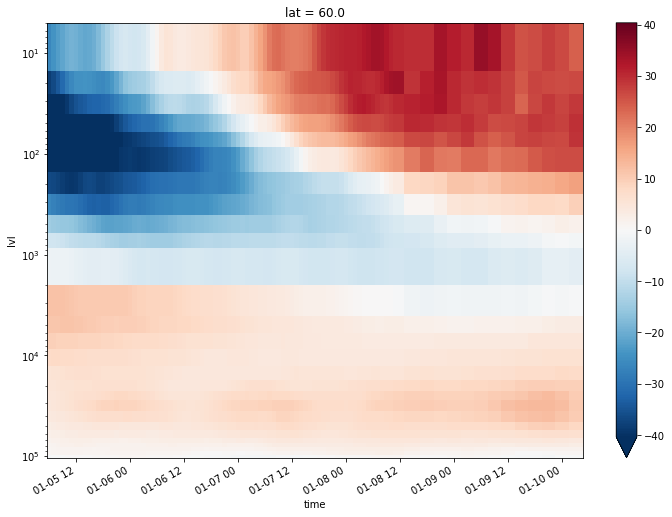

In [109]:
temp.plot(x = 'time', yincrease = False, robust = True, size = 8)
plt.yscale('log')

In [141]:
temp2 = ds_out.sel(lvl = 1000).to_dataset(name = 'zw').load()#.mean('lon').load()
temp2 = temp2.assign_coords(lon=(((temp2.lon + 180) % 360) - 180)).sortby('lon')
temp2

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 91)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-05T06:00:00 ... 2021-01-10T03:00:00
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
    lvl      int64 1000
Data variables:
    zw       (time, lat, lon) float64 0.9439 0.9439 0.9439 ... -25.84 -25.84

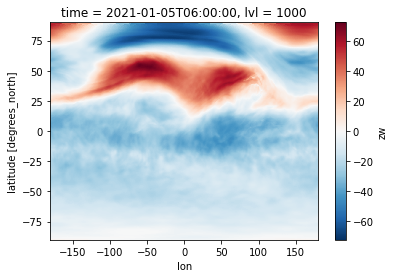

In [142]:
temp2['zw'][0].plot()

In [148]:
temp2.to_netcdf('temp2.nc')

In [145]:
temp2['zw'].sel(lon = slice(-130,-60), lat = slice(20,50)).reset_coords(drop=True).hvplot(x = 'lon', y = 'lat', geo = True, coastline = True)

KeyError: 1609826400000000000

:DynamicMap   [time]

In [124]:
temp2.hvplot.quadmesh(
    'lon', 'lat', 'zw', projection=ccrs.Orthographic(0, 90),
    frame_height=540, cmap='viridis',
    coastline=True, 
)

KeyError: 1609826400000000000

:DynamicMap   [time]